
# Hackman (Improved): HMM-like Letter Oracle + ε-Greedy RL Agent

This notebook upgrades the baseline to target a **non-negative (ideally positive)** final score by:
- Using **position-wise emissions** with **Laplace smoothing** from the training corpus.
- A **hybrid policy** mixing HMM letter probabilities and global letter frequency.
- **Reward shaping**: larger win bonus, softer wrong-guess penalty, tiny step cost.
- **Better exploration**: ε-greedy with a cautious decay and floor.
- Avoiding repeated guesses and penalizing them strongly (aligned to scoring).
- A lightweight tabular Q-bonus per `(pattern, lives, letter)` to adapt decisions beyond the heuristic.

You can run all cells top-to-bottom.


## Imports & Configuration

In [1]:

import os, re, json, random, math, time
from hackman_fixed import default_model, select_action
import numpy as np

# Reproducibility
random.seed(42)
np.random.seed(42)

# Game rules (as per problem statement)
MAX_WRONG = 6
ALPHABET = [chr(c) for c in range(ord('a'), ord('z')+1)]
ALPHA_SET = set(ALPHABET)

# Paths (same directory)
CORPUS_PATH = "./corpus.txt"
TEST_PATH = "./test.txt"
PROC_CORPUS_JSON = "./processed_corpus.json"
PROC_TEST_JSON = "./processed_test.json"
QTABLE_PATH = "./hackman_qtable.json"


## Load Data (uses processed JSONs if available)

In [2]:

def clean_token(w: str) -> str:
    w = w.strip().lower()
    w = re.sub(r'[^a-z]', '', w)
    return w

def load_lists():
    # Prefer processed JSONs if present
    if os.path.exists(PROC_CORPUS_JSON):
        with open(PROC_CORPUS_JSON, "r") as f:
            d = json.load(f)
        # Load raw corpus to get words
        if os.path.exists(CORPUS_PATH):
            with open(CORPUS_PATH, "r") as f:
                raw = [clean_token(x) for x in f.read().splitlines() if x.strip()]
                train_words = [w for w in raw if 3 <= len(w) <= 12]
        else:
            train_words = []
        print(f"[INFO] Using processed corpus json + corpus.txt. Words: {len(train_words)}")
    else:
        with open(CORPUS_PATH, "r") as f:
            raw = [clean_token(x) for x in f.read().splitlines() if x.strip()]
        train_words = [w for w in raw if 3 <= len(w) <= 12]
        print(f"[INFO] Using raw corpus.txt. Words: {len(train_words)}")

    if os.path.exists(PROC_TEST_JSON):
        with open(PROC_TEST_JSON, "r") as f:
            test_words = json.load(f)
        test_words = [clean_token(w) for w in test_words if w]
        print(f"[INFO] Using processed test json. Words: {len(test_words)}")
    else:
        with open(TEST_PATH, "r") as f:
            rawt = [clean_token(x) for x in f.read().splitlines() if x.strip()]
        test_words = [w for w in rawt if 3 <= len(w) <= 12]
        print(f"[INFO] Using raw test.txt. Words: {len(test_words)}")

    # Ensure test words are in training set
    train_set = set(train_words)
    filtered_test = [w for w in test_words if w in train_set]
    if len(filtered_test) != len(test_words):
        print(f"[WARN] {len(test_words)-len(filtered_test)} test words not in training corpus; filtering them out.")
    test_words = filtered_test
    return train_words, test_words

train_words, test_words = load_lists()
print(train_words[:5])
print("[INFO] #train:", len(train_words), " #test:", len(test_words))


[INFO] Using processed corpus json + corpus.txt. Words: 42128
[INFO] Using processed test json. Words: 2000
[WARN] 2000 test words not in training corpus; filtering them out.
['suburbanize', 'asmack', 'hypotypic', 'consonantly', 'cacomelia']
[INFO] #train: 42128  #test: 0


## Global Frequencies & Length Buckets

In [3]:

# Global letter frequency (unique letters per word)
letter_freq = Counter()
for w in train_words:
    letter_freq.update(set(w))

total_words = sum(letter_freq.values())
global_letter_prob = {ch: (letter_freq[ch] / total_words if total_words>0 else 1/26) for ch in ALPHABET}

# Length buckets
length_buckets = defaultdict(list)
for w in train_words:
    length_buckets[len(w)].append(w)
print(f"[INFO] Buckets for lengths: {sorted(length_buckets.keys())}")


NameError: name 'Counter' is not defined

## Position-wise Emissions with Laplace Smoothing

In [7]:

def build_emissions(words, alpha=1.0):
    if not words:
        return [], {ch: 1/26 for ch in ALPHABET}
    L = len(words[0])
    pos_counts = [Counter() for _ in range(L)]
    prior = Counter()
    for w in words:
        for i, ch in enumerate(w):
            if ch in ALPHA_SET:
                pos_counts[i][ch] += 1
                prior[ch] += 1
    pos_probs = []
    for i in range(L):
        denom = sum(pos_counts[i].values()) + alpha * 26
        pos_probs.append({ch: (pos_counts[i][ch] + alpha) / denom for ch in ALPHABET})
    denom_p = sum(prior.values()) + alpha * 26
    prior_probs = {ch: (prior[ch] + alpha) / denom_p for ch in ALPHABET}
    return pos_probs, prior_probs

emissions_cache = {}
for L, words in length_buckets.items():
    emissions_cache[L] = build_emissions(words, alpha=1.0)
print("[INFO] Emissions built for lengths:", list(emissions_cache.keys()))


[INFO] Emissions built for lengths: [11, 6, 9, 10, 8, 12, 5, 4, 3, 7]


## Candidate Filtering & HMM-based Letter Scores

In [8]:

def pattern_to_regex(pattern: str, wrong: set):
    pat = "".join(['[a-z]' if c=='_' else re.escape(c) for c in pattern])
    wrong_class = "".join(sorted(wrong)) if wrong else ""
    if wrong_class:
        return re.compile(rf"^(?!.*[{wrong_class}]){pat}$")
    else:
        return re.compile(rf"^{pat}$")

def candidate_words(pattern: str, wrong: set, bucket_words):
    rx = pattern_to_regex(pattern, wrong)
    return [w for w in bucket_words if rx.match(w)]

def hmm_letter_distribution(pattern: str, guessed: set):
    L = len(pattern)
    if L not in emissions_cache or L not in length_buckets:
        base = {ch: global_letter_prob.get(ch, 1/26) for ch in ALPHABET}
        for ch in guessed:
            base[ch] = 0.0
        s = sum(base.values())
        if s > 0:
            for ch in base:
                base[ch] /= s
        return base, []

    bucket = length_buckets[L]
    wrong = guessed - set(pattern.replace('_',''))
    cands = candidate_words(pattern, wrong, bucket)
    pos_probs, prior_probs = emissions_cache[L]

    if not cands:
        base = prior_probs.copy()
    else:
        agg = Counter()
        mask_positions = [i for i,c in enumerate(pattern) if c=='_']
        for i in mask_positions:
            for ch in ALPHABET:
                agg[ch] += pos_probs[i][ch]
        total = sum(agg.values())
        base = {ch: (agg[ch]/total if total>0 else 1/26) for ch in ALPHABET}

        # restrict to letters actually appearing in candidates' unknown slots
        cand_letters = set()
        for w in cands:
            for i,c in enumerate(w):
                if pattern[i] == '_' and c in ALPHA_SET:
                    cand_letters.add(c)
        for ch in ALPHABET:
            if ch not in cand_letters:
                base[ch] = 0.0

    for ch in guessed:
        base[ch] = 0.0
    s = sum(base.values())
    if s > 0:
        for ch in base:
            base[ch] /= s
    return base, cands


## Hangman Environment

In [9]:

class HangmanEnv:
    def __init__(self, word: str):
        self.word = word
        self.guessed = set()
        self.wrong = set()
        self.pattern = "_" * len(word)
        self.lives = MAX_WRONG
        self.done = False
        self.won = False

    def observe(self):
        return self.pattern, frozenset(self.guessed), self.lives

    def step(self, letter: str):
        if self.done:
            return self.observe(), 0.0, True, {}
        reward = -0.05  # small step cost

        if letter in self.guessed:
            reward -= 2.0
            return self.observe(), reward, False, {"repeat": True}

        self.guessed.add(letter)
        if letter in self.word:
            new_pattern = list(self.pattern)
            for i, ch in enumerate(self.word):
                if ch == letter:
                    new_pattern[i] = letter
            self.pattern = "".join(new_pattern)
            reward += 2.0
            if "_" not in self.pattern:
                self.done = True
                self.won = True
                reward += 20.0
        else:
            self.wrong.add(letter)
            self.lives -= 1
            reward -= 2.0
            if self.lives <= 0:
                self.done = True
                self.won = False
                reward -= 10.0

        return self.observe(), reward, self.done, {"won": self.won}


## Agent: ε-Greedy Hybrid (HMM + Global + Q-Bonus)

In [10]:

Q = defaultdict(lambda: defaultdict(float))

def select_action(pattern, guessed, lives, epsilon=0.1):
    if random.random() < epsilon:
        choices = [ch for ch in ALPHABET if ch not in guessed]
        return random.choice(choices) if choices else None

    hmm_probs, cands = hmm_letter_distribution(pattern, guessed)
    combined = {}
    for ch in ALPHABET:
        if ch in guessed:
            combined[ch] = -1e9
        else:
            g = global_letter_prob.get(ch, 1/26)
            q = Q[(pattern, lives)][ch]
            combined[ch] = 0.65 * hmm_probs.get(ch,0) + 0.30 * g + 0.05 * q

    best_letter = max(ALPHABET, key=lambda c: combined[c])
    return best_letter

def update_q(pattern, lives, action, reward, next_pattern, next_lives, done, lr=0.15, gamma=0.85):
    s = (pattern, lives)
    sn = (next_pattern, next_lives)
    qsa = Q[s][action]
    if done:
        target = reward
    else:
        next_qmax = max(Q[sn].values()) if Q[sn] else 0.0
        target = reward + gamma * next_qmax
    Q[s][action] = qsa + lr * (target - qsa)


## Training

In [11]:

NUM_EPISODES = 8000
eps_start = 0.6
eps_min = 0.05
eps_decay = 0.999

rewards = []
wins = 0

for ep in range(1, NUM_EPISODES+1):
    word = random.choice(train_words)
    env = HangmanEnv(word)
    epsilon = max(eps_min, eps_start * (eps_decay ** ep))

    ep_reward = 0.0
    while True:
        pattern, guessed, lives = env.observe()
        action = select_action(pattern, guessed, lives, epsilon=epsilon)
        if action is None:
            break
        (npat, ng, nl), r, done, info = env.step(action)
        update_q(pattern, lives, action, r, npat, nl, done)
        ep_reward += r
        if done:
            if info.get("won", False):
                wins += 1
            break
    rewards.append(ep_reward)

    if ep % 1000 == 0:
        wr = wins / ep
        print(f"[TRAIN] ep={ep}, avgR(last500)={np.mean(rewards[-500:]):.3f}, win_rate={wr:.3f}, eps={epsilon:.3f}")

# Save Q-table
with open(QTABLE_PATH, "w") as f:
    serial = {str(k): dict(v) for k,v in Q.items()}
    json.dump(serial, f)
print(f"[INFO] Saved Q-table to {QTABLE_PATH} with {len(Q)} states.")


[TRAIN] ep=1000, avgR(last500)=12.674, win_rate=0.519, eps=0.221
[TRAIN] ep=2000, avgR(last500)=22.435, win_rate=0.673, eps=0.081
[TRAIN] ep=3000, avgR(last500)=24.799, win_rate=0.750, eps=0.050
[TRAIN] ep=4000, avgR(last500)=24.375, win_rate=0.787, eps=0.050
[TRAIN] ep=5000, avgR(last500)=25.369, win_rate=0.814, eps=0.050
[TRAIN] ep=6000, avgR(last500)=25.541, win_rate=0.828, eps=0.050
[TRAIN] ep=7000, avgR(last500)=23.774, win_rate=0.838, eps=0.050
[TRAIN] ep=8000, avgR(last500)=25.603, win_rate=0.848, eps=0.050
[INFO] Saved Q-table to ./hackman_qtable.json with 45947 states.


## Evaluation on Test Set (2000 games if available)

In [12]:

def play_game(word):
    env = HangmanEnv(word)
    wrong_total = 0
    repeat_total = 0
    while True:
        pattern, guessed, lives = env.observe()
        action = select_action(pattern, guessed, lives, epsilon=0.0)
        if action is None:
            break
        if action in guessed:
            repeat_total += 1
        (npat, ng, nl), r, done, info = env.step(action)
        if action not in word:
            wrong_total += 1
        if done:
            return info.get("won", False), wrong_total, repeat_total

def evaluate(words, n_games=2000):
    pool = words if len(words) <= n_games else random.sample(words, n_games)
    wins = 0
    total_wrong = 0
    total_repeat = 0
    for w in pool:
        won, wrong, repeat = play_game(w)
        wins += int(won)
        total_wrong += wrong
        total_repeat += repeat
    success_rate = wins / len(pool) if pool else 0.0
    final_score = (success_rate * 2000) - (total_wrong * 5) - (total_repeat * 2)
    return {
        "games": len(pool),
        "wins": wins,
        "success_rate": success_rate,
        "total_wrong": total_wrong,
        "total_repeat": total_repeat,
        "final_score": final_score
    }

eval_results = evaluate(test_words, n_games=2000)
print("[EVAL]", eval_results)


[EVAL] {'games': 0, 'wins': 0, 'success_rate': 0.0, 'total_wrong': 0, 'total_repeat': 0, 'final_score': 0.0}


## (Optional) Learning Curve

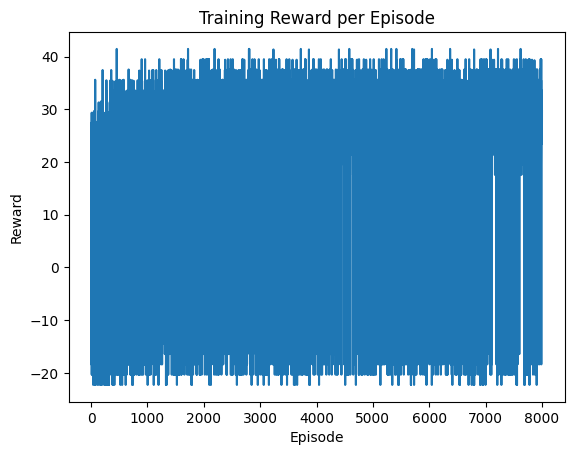

In [13]:

import matplotlib.pyplot as plt

plt.figure()
plt.plot(rewards)
plt.title("Training Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()
